In [2]:
import numpy as np
import pandas as pd
import icpy
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [8]:
environments = [0.1, 1]
POPULATION = 100

data = pd.DataFrame()
data["environment"] = np.concatenate([int(POPULATION/2) * [environment] for environment in environments], axis=0)

data["x_1"] = data.apply(lambda x: np.random.normal(0, 1) * x["environment"], axis=1)
data["y"] = data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1), axis=1)
data["x_2"] = data.apply(lambda x: x["y"] + np.random.normal(0, 1), axis=1)

X = data[["x_1", "x_2", "environment"]].values
y = data["y"].values

In [9]:
data.head()

,environment,x_1,y,x_2
0,0.1,0.022825,0.817946,1.880329
1,0.1,0.180808,0.053776,1.311805
2,0.1,0.058122,0.518741,-0.040066
3,0.1,-0.183321,1.391141,2.099759
4,0.1,0.074105,-0.213751,-1.341969


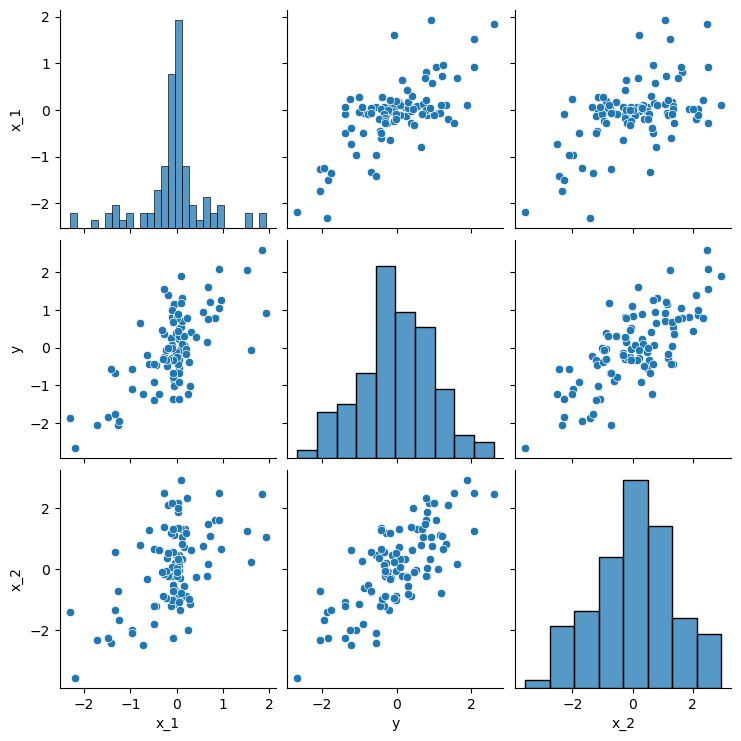

In [10]:
sns.pairplot(data.drop(["environment"], axis=1))

## Two sample t-test on the residuals of $I_e$ against $I_{-e}$

In [11]:
S = []
E = environments  
features = ["x_1", "x_2"]

for i in range(1, 2 + 1):
  S.append(list(itertools.combinations(features, i)))

# for combs in S:
#   for e in E:
#     for s in combs:

#       e_minus = list(set(E) - set([e]))
#       for e_ in e_minus:


In [12]:
combs = S[0]
e = environments[0]
s = combs[0]

e_minus = list(set(E) - set([e]))
e_ = e_minus[0]

print(combs, e, s, e_)

[('x_1',), ('x_2',)] 0.1 ('x_1',) 1


In [13]:
list(set(E) - set([e]))

[1]

In [14]:
fit_all_sample = sm.OLS(endog=data[["y"]], exog=data[list(s)]).fit()
resid_all_sample = fit_all_sample.resid

resid_all_sample_df = data[["environment"]].copy()
resid_all_sample_df["resid"] = resid_all_sample
resid_all_sample_df.tail()

,environment,resid
95,1.0,0.322371
96,1.0,-0.012620
97,1.0,0.389234
98,1.0,0.788079
99,1.0,-0.516420


In [17]:
results_ttest = stats.ttest_ind(a=resid_all_sample_df.loc[resid_all_sample_df["environment"] == e],
                                b=resid_all_sample_df.loc[resid_all_sample_df["environment"] == e_],
                                equal_var=True)
ttest_pval = results_ttest[1][1]

ttest_pval

/var/folders/y5/gwwq15s92v97s_yvjxy3cqn40000gn/T/ipykernel_34983/2304237534.py:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results_ttest = stats.ttest_ind(a=resid_all_sample_df.loc[resid_all_sample_df["environment"] == e],


0.9748700940580499